# Spectral Normalized Gaussian Process (SNGP) Regression

In [1]:
%pip install lightning-uq-box

  Cloning https://github.com/f-dangel/curvlinops to /tmp/pip-install-o93f1msb/curvlinops-for-pytorch_dcc08762483d443e9a440c90d08b4284
  Running command git clone --filter=blob:none --quiet https://github.com/f-dangel/curvlinops /tmp/pip-install-o93f1msb/curvlinops-for-pytorch_dcc08762483d443e9a440c90d08b4284
  Resolved https://github.com/f-dangel/curvlinops to commit d509cd6c332cda0e3bbb7b6bd9c5f37a6aa023b1
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import tempfile
from functools import partial

import torch
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from torch.optim import Adam

from lightning_uq_box.datamodules import ToyDUE
from lightning_uq_box.models.fc_resnet import FCResNet
from lightning_uq_box.uq_methods import SNGPRegression
from lightning_uq_box.viz_utils import (
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

%load_ext autoreload
%autoreload 2

/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# temporary directory for saving
my_temp_dir = tempfile.mkdtemp()

seed_everything(42)

Seed set to 42


42

## Datamodule

In [4]:
datamodule = ToyDUE(batch_size=128, n_samples=1000)
datamodule.__dict__.keys()
X_train, Y_train, X_test, Y_test, train_loader, test_loader = (
    datamodule.X_train,
    datamodule.Y_train,
    datamodule.X_test,
    datamodule.Y_test,
    datamodule.train_dataloader(),
    datamodule.val_dataloader(),
)

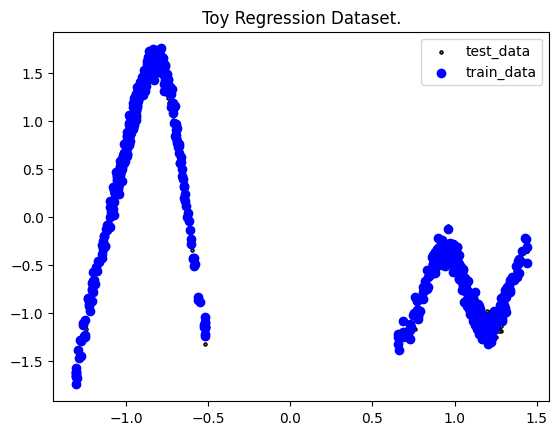

In [5]:
fig = plot_toy_regression_data(X_train, Y_train, X_test, Y_test)

## Model

In [6]:
feature_extractor = FCResNet(input_dim=1, features=128, depth=4)

In [7]:
sngp = SNGPRegression(
    feature_extractor=feature_extractor,
    loss_fn=torch.nn.MSELoss(),
    optimizer=partial(Adam, lr=1e-3),
)

## Trainer

In [8]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=300,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(sngp, datamodule)

Missing logger folder: /tmp/tmp2zxp8n1r/lightning_logs

  | Name              | Type                  | Params
------------------------------------------------------------
0 | feature_extractor | FCResNet              | 66.3 K
1 | loss_fn           | MSELoss               | 0     
2 | normalize         | LayerNorm             | 256   
3 | rff               | RandomFourierFeatures | 0     
4 | beta              | Linear                | 1.0 K 
5 | train_metrics     | MetricCollection      | 0     
6 | val_metrics       | MetricCollection      | 0     
7 | test_metrics      | MetricCollection      | 0     
------------------------------------------------------------
67.6 K    Trainable params
0         Non-trainable params
67.6 K    Total params
0.270     Total estimated model params size (MB)
/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottlen

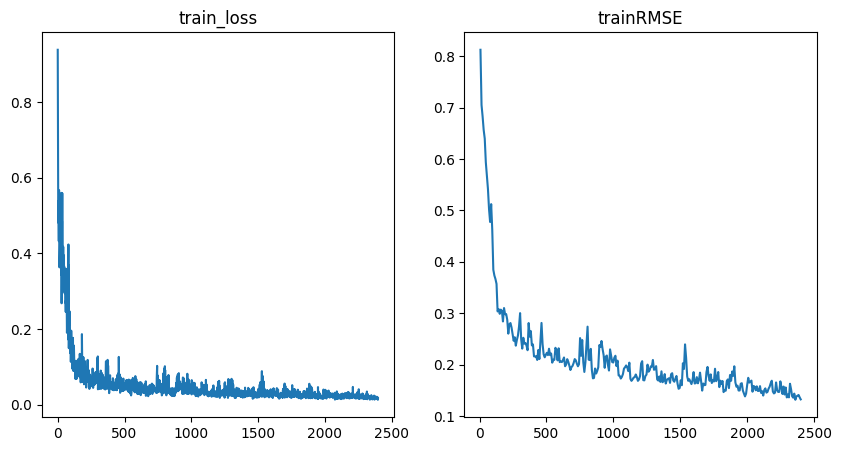

In [10]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

## Prediction

In [11]:
preds = sngp.predict_step(X_test)

In [13]:
for key, val in preds.items():
    print(key, val.shape)

pred torch.Size([200, 1])
pred_uct torch.Size([200])
epistemic_uct torch.Size([200])
pred_cov torch.Size([200, 200])


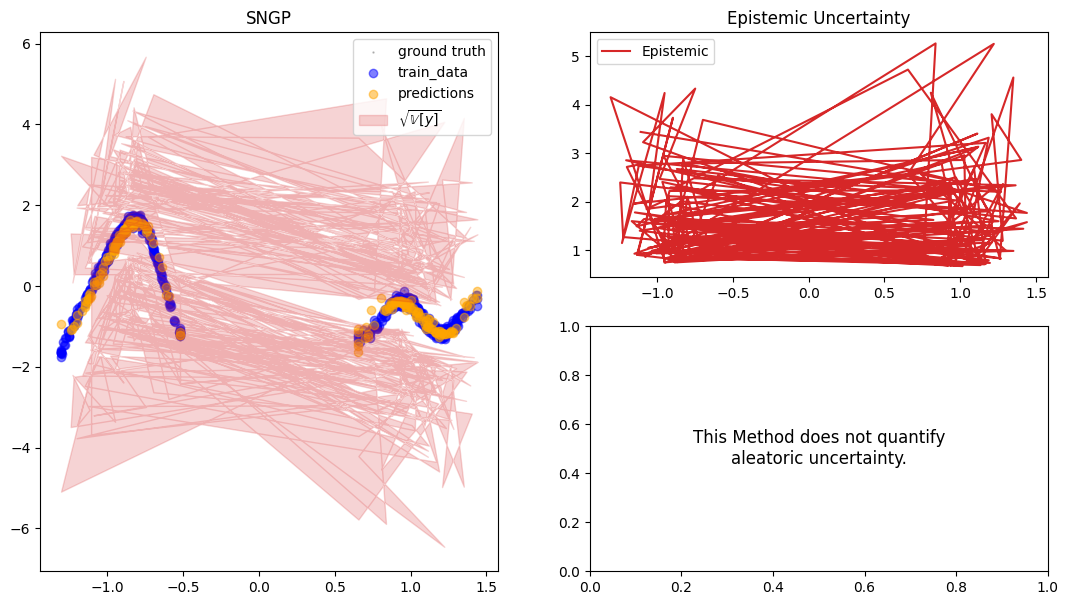

In [14]:
fig = plot_predictions_regression(
    X_train,
    Y_train,
    X_test,
    Y_test,
    preds["pred"].squeeze(),
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    title="SNGP",
    show_bands=False,
)